In [196]:
import datetime 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    GridSearchCV, learning_curve, train_test_split, validation_curve)
from sklearn.preprocessing import StandardScaler
from tensorflow.python.framework import ops
from tensorflow.python.ops import control_flow_ops

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('ggplot')

In [194]:
DATA_PATH = '../data/'

In [3]:
!../scripts/copy_data.sh
!ls -la ../data

total 2624
drwxr-xr-x   6 dsp  staff      204 Sep 30 17:04 .
drwxr-xr-x  11 dsp  staff      374 Sep 30 21:18 ..
-rw-r--r--@  1 dsp  staff     6148 Sep 30 17:04 .DS_Store
-rw-r--r--@  1 dsp  staff    64799 Sep 30 16:49 Multistock.csv
-rw-r--r--@  1 dsp  staff    86654 Oct 14 01:48 buyStats.csv
-rw-r--r--@  1 dsp  staff  1175781 Oct 13 21:20 sp1950.csv


In [4]:
def read(filepath, pred=False):
    dat = pd.read_csv(filepath)
    if not pred:
        dat['buyDate'] = pd.to_datetime(dat['buyDate'])
    return dat

In [5]:
dat = read(DATA_PATH + 'buyStats.csv')

In [6]:
def remove_commas(value):
    if type(value) == str:
        return float(value.replace(',', ''))
    else:
        return value

In [7]:
dat['freeCashFlow_'] = dat['freeCashFlow_'].apply(lambda x: remove_commas(x))
dat['mCap_'] = dat['mCap_'].apply(lambda x: remove_commas(x))

In [8]:
dat['industry'] = dat['industry'].apply(lambda x: str(x))
dat['sector']   = dat['sector'].apply(lambda x: str(x))
industries = sorted(np.unique(dat['industry']))
sectors    = sorted(np.unique(dat['sector']))
[print(ind, end=', ') for ind in industries]
print('\n')
[print(sec, end=', ') for sec in sectors]

aerospaceAndDefense, airlines, autoComponents, automobiles, banks, beverages, biotechnology, buildingProducts, capitalMarkets, chemicals, commercialServicesAndSupplies, communicationEquipment, constructionAndEngineering, constructionMaterials, diversifiedConsumerServices, diversifiedTelecommunicationServices, electricUtilities, electronicEquipmentInstrumentsAndComponents, energyEquipmentAndServices, equityRealEstateInvestmentTrusts, foodAndStaplesRetailing, foodProducts, gasUtilities, healthCareEquipmentAndSupplies, healthCareProvidersAndServices, healthCareTechnology, hotelsRestaurantsAndLeisure, householdDurables, independentPowerAndRenewableElectricityProducers, industrialConglomerates, insurance, internetAndDirectMarketingRetail, internetSoftwareAndServices, itServices, leisureProducts, lifeSciencesToolsAndServices, machinery, media, metalsAndMining, mortgageRealEstateInvestmentTrusts, nan, oilGasAndConsumableFuels, paperAndForestProducts, personalProducts, pharmaceuticals, profess

[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [12]:
def one_hot(df):
    X = df.copy()
    X[industries] = pd.get_dummies(X['industry'])
    X[sectors]    = pd.get_dummies(X['sector'])
    X[['mfHold', 'mfNone', 'mfNow', 'mfStart']] = pd.get_dummies(X['MF'])
    X = X.drop(['industry', 'size', 'sector', 'MF'], axis=1)
    return X

In [13]:
dat = one_hot(dat)

In [14]:
def median_fill(df):
    X = df.copy()

    for col in list(X):
        try:
            X[col][np.isnan(X[col])] = np.nanmedian(X[col])
        except:
            print('Could not fill column', col)
    return X

In [15]:
dat = median_fill(dat)

Could not fill column stock
Could not fill column buyDate


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [16]:
today = datetime.datetime.now()
if today.weekday() == 5:
    today = today - datetime.timedelta(days=1)
if today.weekday() == 6:
    today = today - datetime.timedelta(days=2)
today = str(today).split(' ')[0]
today = pd.to_datetime(today)
today

Timestamp('2017-10-13 00:00:00')

In [17]:
new_dat = dat.loc[dat['buyDate'] > today, :]
dat     = dat.loc[dat['buyDate'] <= today, :]
stocks = new_dat['stock']

In [18]:
def drop_missing(dfs, y_col):
    X = dfs[0].copy()
    # cols
    drop_cols = [col for col in list(X) if type(col[0]) == np.float and col.isnan().all()]
    X = X.drop(drop_cols, axis=1)
    X2 = dfs[1].drop(drop_cols, axis=1)
    return X.loc[np.isnan(dat[y_col]) == False, :], X2

In [19]:
dat, new_dat = drop_missing([dat, new_dat], 'd30Gains')

In [20]:
def split_xy(df, y_col, first_X):
    y = df[y_col]
    start_col = list(df).index(first_X)
    X = df.iloc[:, start_col:]
    return X, y

In [21]:
X, y         = split_xy(dat,     'd30Gains', 'MFRisk')
X_new, y_new = split_xy(new_dat, 'd30Gains', 'MFRisk')
[print('Mismatch:', x, xn) for (x, xn) in zip(list(X), list(X_new)) 
 if x != xn]

[]

In [22]:
n = X.shape[0]
TRAIN = 0.7
VALIDATE = 0.15
TEST = 0.15
print(
    'Training size:   %.0f\nValidation size: %.0f\nTest       size: %.0f'
    %(TRAIN * n, VALIDATE * n, TEST * n))

Training size:   170
Validation size: 36
Test       size: 36


In [23]:
# Train, Not Train
X_train, X_vt, y_train, y_vt = train_test_split(
    X, y, test_size=VALIDATE + TEST)

# Validate Test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_vt, y_vt, test_size=(TEST / (TEST + VALIDATE)))

# Reindex
X_train.index = range(len(y_train))
y_train.index = range(len(y_train))

X_valid.index = range(len(y_valid))
y_valid.index = range(len(y_valid))

X_test.index = range(len(y_test))
y_test.index = range(len(y_test))
y_test = y_test.values.reshape(-1, 1)

In [24]:
print('train:   ', X_train.shape)
print('validate:', X_valid.shape)
print('test:    ', X_test.shape)
print('new:     ', X_new.shape)

train:    (170, 125)
validate: (36, 125)
test:     (37, 125)
new:      (14, 125)


In [25]:
# WHILE DATA SET IS SMALL, restrict values in new data to the range seen 
# in training data
if X_test.shape[0] < 100:
    for col in list(X_train):
        if col not in ['spVal', 'days']:
            mn, mx = np.min(X_train[col]), np.max(X_train[col])
            X_new[col][X_new[col] < mn] = mn
            X_new[col][X_new[col] > mx] = mx
else: 
    print('Data large enough.  Remove this cell.')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
remove_empties = []

for col in list(X_train):
    try:
        if np.isnan(X_train[col]).any():
            remove_empties.append(col)
            print('Removing ', col)
    except:
        print('\tCould not check', col)
        
X_train = X_train.drop(remove_empties, axis=1)
X_valid = X_valid.drop(remove_empties, axis=1)
X_test  = X_test.drop(remove_empties, axis=1)
X_new   = X_new.drop(remove_empties, axis=1)

In [27]:
# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
X_new  = scaler.transform(X_new)

# Ridge Regression Model for Baseline

In [203]:
pipe_ridge = Pipeline([(
    'clf', Ridge(random_state = 11235, max_iter = 5000))])
alpha_range = np.linspace(0, 5000, 50)
train_scores, test_scores = validation_curve(estimator = pipe_ridge,
                                             X = X_train,
                                             y = y_train,
                                             param_name = 'clf__alpha',
                                             param_range = alpha_range,
                                             cv = 30,
                                             n_jobs = -1)
train_mean = np.mean(train_scores, axis = 1)
train_std  = np.std(train_scores,  axis = 1)
test_mean  = np.mean(test_scores,  axis = 1)
test_std   = np.std(test_scores,   axis = 1)

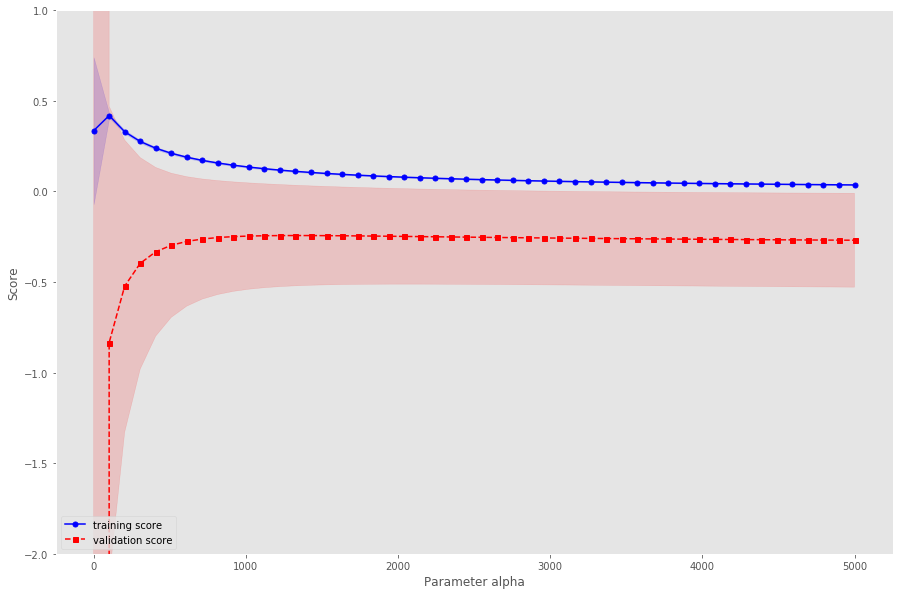

In [204]:
plt.plot(alpha_range,
         train_mean,
         color = 'blue',
         marker = 'o',
         markersize = 5,
         label = 'training score');
plt.fill_between(alpha_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15,
                color = 'blue');
plt.plot(alpha_range,
         test_mean,
         color = 'red',
         linestyle = '--',
         marker = 's',
         markersize = 5,
         label = 'validation score');
plt.fill_between(alpha_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15,
                 color = 'red');
plt.grid();
plt.legend(loc = 'lower left');
#plt.xscale('log');
plt.xlabel('Parameter alpha');
plt.ylabel('Score');
plt.ylim([-2, 1]);
#plt.xlim([0, 300]);

In [205]:
best_alpha = alpha_range[np.where(test_mean == max(test_mean))]
best_alpha

array([ 1326.53061224])

In [208]:
best_ridge = Ridge(alpha = best_alpha)
best_ridge.fit(X_train, y_train)

Ridge(alpha=array([ 1326.53061]), copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [213]:
preds = best_ridge.predict(X_valid)
rmse_ridge = np.sqrt(((preds - y_valid) ** 2).sum() / len(y_valid))
rmse_ridge

0.080423557592070177

In [237]:
list(stocks)

['jd',
 'masi',
 'tmus',
 'nyt',
 'ndaq',
 'mtch',
 'mtn',
 'sbux',
 'dis',
 'mmm',
 'pypl',
 'mkc',
 'intu',
 'kmi']

In [246]:
pred_new = best_ridge.predict(X_new)
ridge_preds = pd.DataFrame(data=pred_new, columns=['preds'])
ridge_preds['stock'] = list(stocks)
ridge_preds = ridge_preds.sort_values('preds', ascending=False)
ridge_preds.head(len(stocks))

,preds,stock
10,1.024182,pypl
5,1.022304,mtch
1,1.017633,masi
4,1.016506,ndaq
11,1.012054,mkc
13,1.011709,kmi
9,1.011428,mmm
3,1.010969,nyt
12,1.009946,intu
8,1.009001,dis


# Neural Net

In [28]:
#!mkdir stock_model_logs

In [29]:
def batch_norm(x, n_out, phase_train, layer_type):
    beta_init  = tf.constant_initializer(value=0.0, dtype=tf.float32)
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    beta  = tf.get_variable('beta',  [n_out], initializer=beta_init)
    gamma = tf.get_variable('gamma', [n_out], initializer=gamma_init)
    axes = [0, 1, 2] if layer_type == 'conv' else [0]
    batch_mean, batch_var = tf.nn.moments(x, axes, name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    
    def  mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    mean, var = control_flow_ops.cond(
        phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))
    
    if layer_type != 'conv':
        x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(
        x, mean, var, beta, gamma, 1e-3, True)
    
    if layer_type != 'conv':
        normed = tf.reshape(normed, [-1, n_out])
    return normed

In [30]:
def layer_batch_norm(x, n_out, phase_train):
    return batch_norm(x, n_out, phase_train, 'fully_connected')

In [31]:
# Create a fully-connected layer
def layer(input, weight_shape, bias_shape, phase_train):
    weight_init = tf.random_normal_initializer(
        stddev=(2. / weight_shape[0]) ** 0.5)  # He
        #stddev=(2. / (weight_shape[0] + weight_shape[1])) ** 0.5) # Xavier
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable('W', weight_shape, initializer=weight_init)
    b = tf.get_variable('b', bias_shape, initializer=bias_init)
    logits = tf.matmul(input, W) + b
    return tf.nn.relu(layer_batch_norm(  # <- or tanh
        logits, weight_shape[1], phase_train))

In [32]:
# Make with 2 fc layers, then update to generalize
def inference(x, keep_prob, phase_train, n_neurons):
    inputs = x
    for i in range(len(n_neurons) - 1):
        with tf.variable_scope('fc' + str(i + 1)):
            inputs = layer(inputs, 
                           [n_neurons[i], n_neurons[i + 1]],
                           n_neurons[i + 1],
                           phase_train)
            inputs = tf.nn.dropout(inputs, keep_prob)
    return inputs

In [33]:
def loss(output, y):
    #cost = tf.reduce_sum(tf.pow(output - y, 2)) # SSE
    cost = tf.sqrt(
        tf.reduce_mean(tf.square(tf.subtract(y, output)))) # RMSE
    return cost

In [34]:
def training(cost, global_step):
    #tf.summary.scalar('cost', cost)
    eta0 = ETA
    eta = tf.train.exponential_decay(
        eta0, global_step, DECAY_STEPS, DECAY_RATE, name='eta')
    optimizer = tf.train.AdamOptimizer(eta)
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [35]:
ops.reset_default_graph()
g = tf.get_default_graph()
[op.name for op in g.get_operations()]

[]

In [36]:
def training(cost, global_step):
    #tf.summary.scalar('cost', cost)
    optimizer = tf.train.AdamOptimizer(ETA)
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [37]:
# Run only before first model is executed
best_error_so_far = np.Inf

In [187]:
N, D = X_train.shape

# Hyperparmeters to tune
DROPOUT_RATE = 0.12
n_neurons = [D, D, D, D, D, D, 1]

# Programmed Learning with Decay
ETA = 0.005 # Learning rate
DECAY_STEPS = 100  # eta updates after this many epochs
DECAY_RATE = 0.99  # factor to change eta by

BATCH_SIZE = 64
EPOCHS = 15000

DISPLAY_STEP = 200

In [188]:
train_err = []
valid_err = []

with tf.device('/gpu:0'):
    with tf.Graph().as_default():
        with tf.variable_scope('stock_mod'):
            # Init
            X = tf.placeholder(tf.float32, shape=[None, D], name='X')
            y = tf.placeholder(tf.float32, shape=None, name='y')
            keep_prob = tf.placeholder(tf.float32)
            phase_train = tf.placeholder(tf.bool) # T=train, F=Valid/Test
            output = inference(X, keep_prob, phase_train, n_neurons)
            cost = loss(output, y)
            global_step = tf.Variable(
                0, name='global_step', trainable=False)
            train_op = training(cost, global_step)
            saver = tf.train.Saver()
            sess = tf.Session()
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
            tf.train.start_queue_runners(sess=sess)
            
            # Train
            for epoch in range(EPOCHS):
                avg_rmse = 0.
                idxs = np.random.permutation(range(N))
                n_batches = len(idxs) // BATCH_SIZE
                
                for batch in range(n_batches):
                    _, new_cost = sess.run(
                        [train_op, cost],
                        feed_dict={X: X_train[idxs, :],
                                   y: y_train[idxs],
                                   keep_prob: 1 - DROPOUT_RATE,
                                   phase_train: True})
                avg_rmse += new_cost / n_batches
                train_err.append(avg_rmse)

                validate_rmse = sess.run(
                    cost,
                    feed_dict={X: X_valid,
                               y: y_valid,
                               keep_prob: 1.,
                               phase_train: False})
                valid_err.append(validate_rmse)

                # Display output per display step
                if epoch % DISPLAY_STEP == 0:
                    print('Epoch: %04d Cost: %.8f\tValidation cost: %.8f' 
                          %(epoch + 1, avg_rmse, validate_rmse))

                    saver.save(sess, 
                               'stock_model_logs/model.ckpt', 
                               global_step=global_step)
            print('Optimization complete...')
            test_rmse = sess.run(cost, 
                                feed_dict={X: X_test,
                                           y: y_test,
                                           keep_prob: 1.,
                                           phase_train: False})
            print('Test RMSE: %.8f\n\n' %test_rmse)
            
            new_preds = sess.run(output, 
                                 feed_dict={X: X_new,
                                            keep_prob: 1., 
                                            phase_train: False})
            final_out = []
            for (stock, pred) in zip(
                    stocks, new_preds.reshape(new_preds.shape[0])):
                final_out.append([stock, pred])
    
            out = pd.DataFrame(columns=['Stock', 'Prediction'], 
                               data=final_out)
            out['LowerBound'] = out['Prediction'] - 2 * test_rmse
            out['UpperBound'] = out['Prediction'] + 2 * test_rmse
            out = out.sort_values('Prediction', ascending=False)
            print(out.head(len(stocks)))

Epoch: 0001 Cost: 0.40780780	Validation cost: 1.02117503
Epoch: 0201 Cost: 0.22762090	Validation cost: 0.18562771
Epoch: 0401 Cost: 0.20300350	Validation cost: 0.18501712
Epoch: 0601 Cost: 0.20300527	Validation cost: 0.18400052
Epoch: 0801 Cost: 0.18750225	Validation cost: 0.18407060
Epoch: 1001 Cost: 0.18342398	Validation cost: 0.18403010
Epoch: 1201 Cost: 0.19924150	Validation cost: 0.18536009
Epoch: 1401 Cost: 0.21740098	Validation cost: 0.18444216
Epoch: 1601 Cost: 0.18749993	Validation cost: 0.18170607
Epoch: 1801 Cost: 0.19923867	Validation cost: 0.18407451
Epoch: 2001 Cost: 0.20669436	Validation cost: 0.18394010
Epoch: 2201 Cost: 0.18750057	Validation cost: 0.18510979
Epoch: 2401 Cost: 0.22760315	Validation cost: 0.18417341
Epoch: 2601 Cost: 0.18750449	Validation cost: 0.18235841
Epoch: 2801 Cost: 0.19540392	Validation cost: 0.18310298
Epoch: 3001 Cost: 0.22085226	Validation cost: 0.18165453
Epoch: 3201 Cost: 0.20300403	Validation cost: 0.18480864
Epoch: 3401 Cost: 0.21033064	Va

In [189]:
#print(np.mean(y_train))
print(np.std(y_train))

0.0863518090966


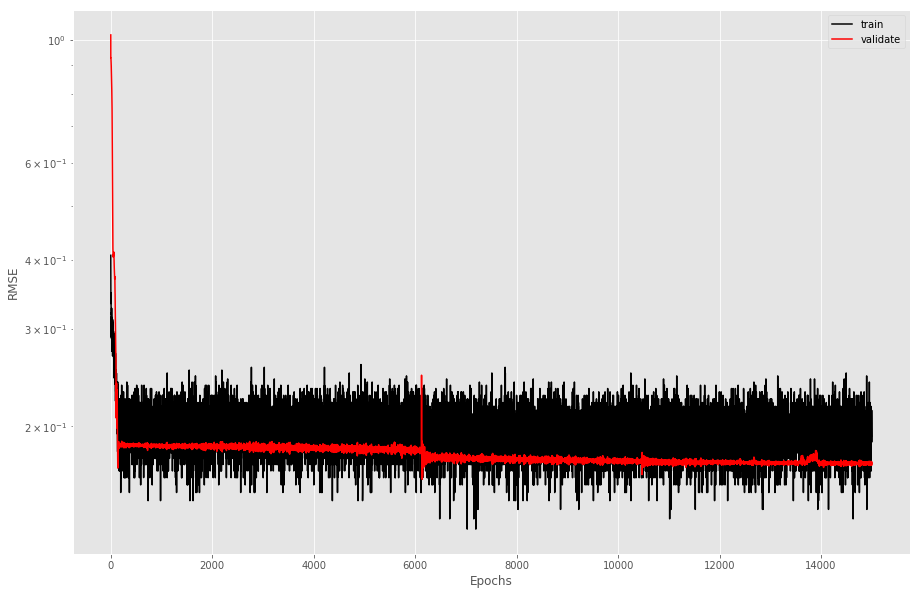

In [190]:
plt.plot(train_err, 'k-', label='train');
plt.plot(valid_err, 'r-', label='validate');
plt.legend(loc='best');
plt.xlabel('Epochs');
plt.ylabel('RMSE');
plt.yscale('log')
#plt.xscale('log')

In [191]:
appx_validation_error = np.mean(valid_err[-100:])
print('Previous Best:', best_error_so_far)
print('This run:     ', appx_validation_error)

Previous Best: 0.189844
This run:      0.171361


In [192]:
if appx_validation_error < best_error_so_far:
    best_error_so_far = appx_validation_error
    print('New Best Model Found!\nHyperparameters:\n' + ('-' * 70))
    hyperparams = {
        'best_error_so_far': appx_validation_error,
        'best_dropout': DROPOUT_RATE,
        'best_architecture': n_neurons,
        'best_eta': ETA,
        'best_decay_steps': DECAY_STEPS,
        'best_decay_rate': DECAY_RATE,
        'epochs': EPOCHS}
for k, v in hyperparams.items():
    print('%17s: %s' %(k, str(v)))

New Best Model Found!
Hyperparameters:
----------------------------------------------------------------------
best_error_so_far: 0.171361
     best_dropout: 0.12
best_architecture: [125, 125, 125, 125, 125, 125, 1]
         best_eta: 0.005
 best_decay_steps: 100
  best_decay_rate: 0.99
           epochs: 15000
